In [75]:
import kagglehub

# Download dataset and get local path
path = kagglehub.dataset_download("stephanmatzka/predictive-maintenance-dataset-ai4i-2020")

print("Downloaded dataset to:", path)
import os

# List files in the directory
print("Files in path:")
print(os.listdir(path))
import pandas as pd
data = pd.read_csv(os.path.join(path, "ai4i2020.csv"))
print(data.head())
data = data.drop(columns=['UDI', 'Product ID'])
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Type'] = le.fit_transform(data['Type'])  # L=0, M=1, H=2
data['feature1'] = data['Torque [Nm]'] * data['Rotational speed [rpm]']
data['feature2'] = data['Process temperature [K]'] - data['Air temperature [K]']
safe_tool_wear = data['Tool wear [min]'].replace(0, 1e-6)
data['feature3'] = data['Rotational speed [rpm]'] - safe_tool_wear
data['feature4'] = data['Process temperature [K]'] / safe_tool_wear
data['feature5'] = data['feature3'] * data['feature4']

failure_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
# data['num_failure_types'] = data[failure_cols].sum(axis=1)
# data = data.drop(columns=failure_cols)
# data = data.drop(columns=['num_failure_types'])
# data = data.drop(columns=['Rotational speed [rpm]'])


Downloaded dataset to: /kaggle/input/predictive-maintenance-dataset-ai4i-2020
Files in path:
['ai4i2020.csv']
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0              

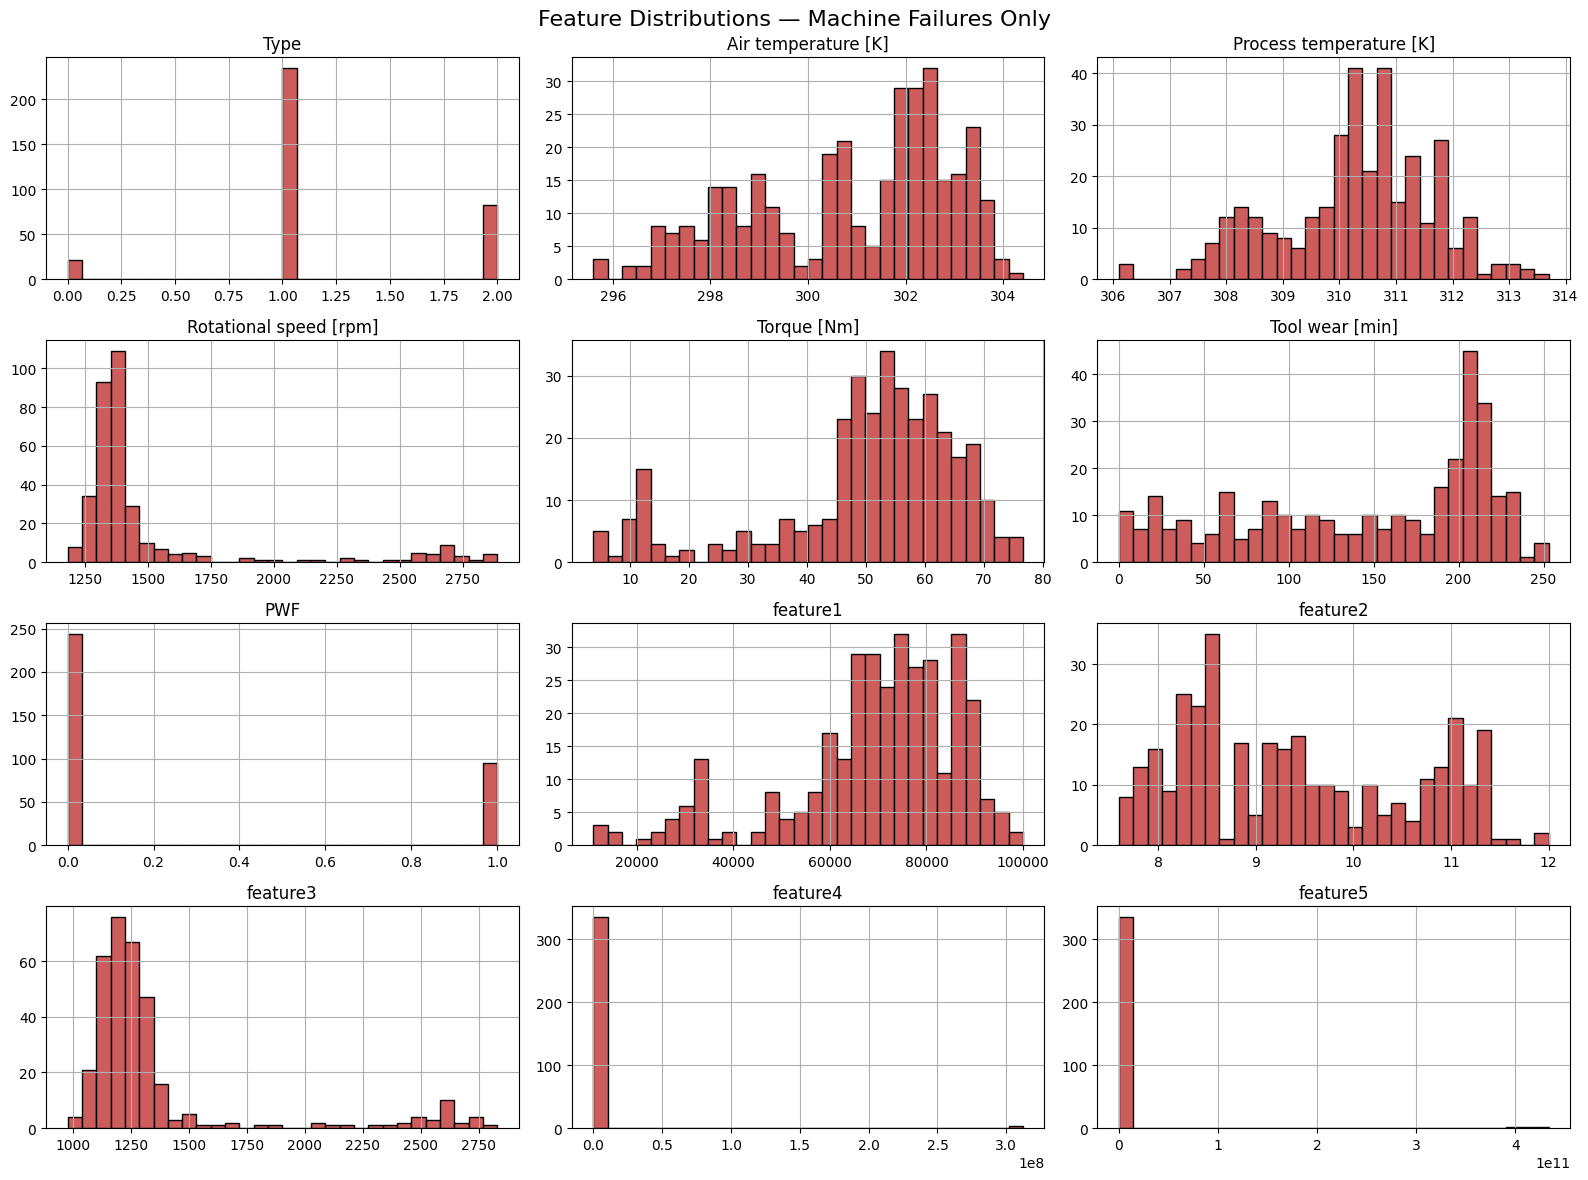

In [76]:
import matplotlib.pyplot as plt

# Filter rows where machine failure occurred
failure_data = data[data['Machine failure'] == 1]

# Drop the target column so we only plot features
features_only = failure_data.drop(columns=['Machine failure'])
features_only = features_only.drop(columns=['TWF'])
features_only = features_only.drop(columns=['HDF'])
features_only = features_only.drop(columns=['OSF'])
features_only = features_only.drop(columns=['RNF'])

# Plot histograms of all features for failure cases
features_only.hist(
    bins=30,
    figsize=(16, 12),
    edgecolor='black',
    color='indianred'
)

plt.suptitle("Feature Distributions — Machine Failures Only", fontsize=16)
plt.tight_layout()
plt.show()


In [90]:
X = data.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
print(data.head())
y = data['Machine failure']


   Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     2                298.1                    308.6                    1551   
1     1                298.2                    308.7                    1408   
2     1                298.1                    308.5                    1498   
3     1                298.2                    308.6                    1433   
4     1                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  \
0         42.8                0                0    0    0    0    0    0   
1         46.3                3                0    0    0    0    0    0   
2         49.4                5                0    0    0    0    0    0   
3         39.5                7                0    0    0    0    0    0   
4         40.0                9                0    0    0    0    0    0   

   feature1  feature2     feature3      feature4  

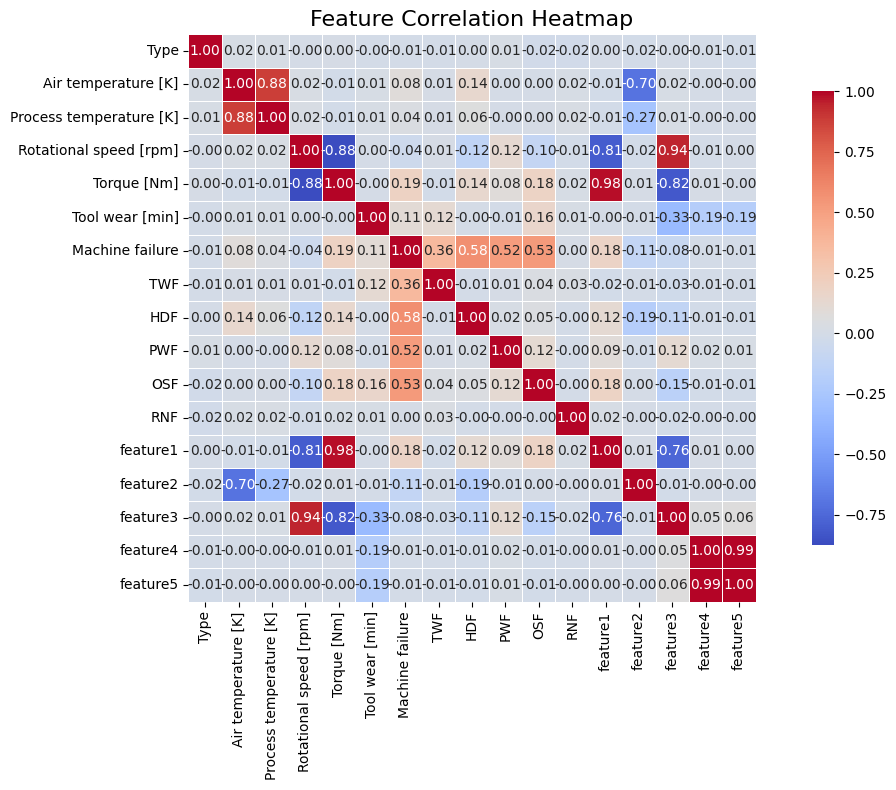

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix (only numeric features)
corr_matrix = data.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

# Title
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


In [130]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=40453
)
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    random_state=4223
)

failure_counts = data['Machine failure'].value_counts()

num_no_failure = failure_counts[0]
num_failure = failure_counts[1]

failure_ratio = num_no_failure / num_failure

print(f"No Failure (0): {num_no_failure}")
print(f"Failure (1):    {num_failure}")
print(f"Assigning weight : No-Failure to Failure Ratio: {failure_ratio:.4f}")

sample_weights = np.where(y_train == 1, 1, 1)

rf.fit(X_train, y_train, sample_weight=sample_weights)


No Failure (0): 9661
Failure (1):    339
Assigning weight : No-Failure to Failure Ratio: 28.4985


RandomForestClassifier(max_depth=20, n_estimators=1000, random_state=42)

In [131]:
# # Predict probabilities (continuous outputs)
# y_pred = rf.predict(X_test)
# from sklearn.metrics import mean_squared_error, r2_score

# # Evaluate regression performance
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print(f"Mean Squared Error: {mse:.4f}")
# print(f"R^2 Score: {r2:.4f}")
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.9925
Precision: 0.9649122807017544
Recall: 0.8088235294117647
F1 Score: 0.88


Accuracy:  0.9925
Precision: 0.9649
Recall:    0.8088
F1 Score:  0.8800


Text(0.5, 1.0, 'Confusion Matrix ')

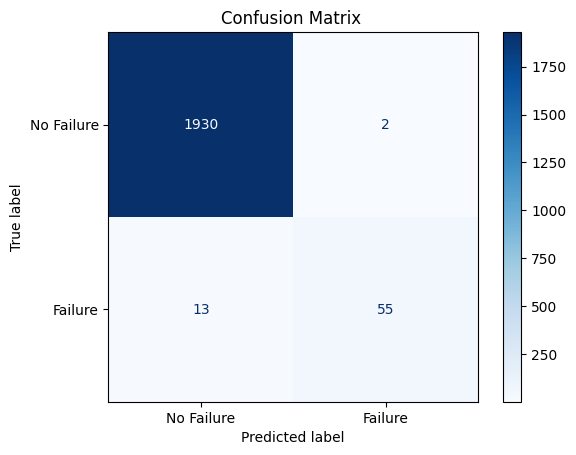

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

n_samples = len(y_test)


# Extract sampled predicted and actual values


y_pred_binary = (y_pred >= 0.5).astype(int)
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix ')

<Figure size 800x600 with 0 Axes>

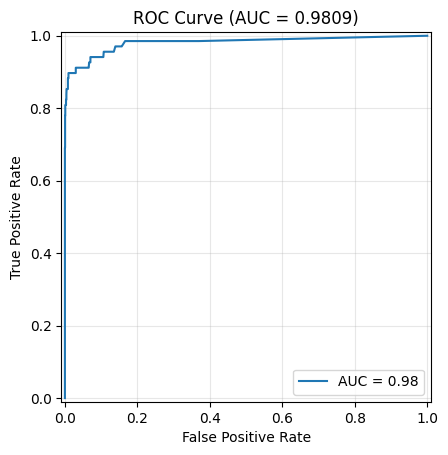

In [133]:
# import matplotlib.pyplot as plt
# import numpy as np
# import random

# # Ensure aligned arrays
# y_test_array = y_test.reset_index(drop=True).values
# y_pred_array = np.array(y_pred)

# # Sample 100 random aligned indices
# sample_indices = random.sample(range(len(y_test_array)), 100)

# # Get sampled predictions and actuals
# y_pred_sampled = y_pred_array[sample_indices]
# y_test_sampled = y_test_array[sample_indices]

# # Add jitter for actuals
# jitter = 0.03
# y_test_jittered = y_test_sampled + np.random.uniform(-jitter, jitter, size=len(y_test_sampled))

# # Plot
# plt.figure(figsize=(12, 6))
# plt.plot(y_pred_sampled, label='Predicted Failure Count', color='royalblue', linewidth=2)
# plt.scatter(range(len(y_test_sampled)), y_test_jittered, label='Actual Failures', color='orangered', alpha=0.7, s=40)

# plt.xlabel('Sampled Test Samples (random order)')
# plt.ylabel('Failure Count')
# plt.title('Predicted vs. Actual Failure Counts (100 Sampled Points)')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.ylim(-0.2, max(max(y_test_jittered), max(y_pred_sampled)) + 1)
# plt.tight_layout()
# plt.show()from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.grid(alpha=0.3)
plt.show()



/tmp/ipython-input-134-821154591.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette='viridis')


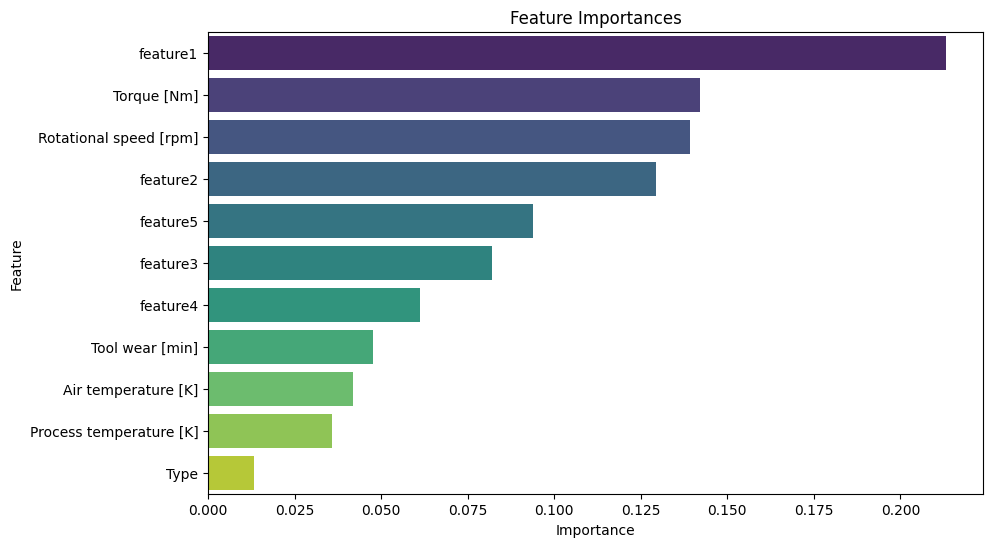

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have:
# y_test (true values)
# y_pred (model predictions on X_test)
# model (your trained RandomForestRegressor)

# # 1. Predicted vs Actual
# plt.figure(figsize=(8,6))
# plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel("Actual Number of Failures")
# plt.ylabel("Predicted Number of Failures")
# plt.title("Predicted vs Actual Failures")
# plt.grid(alpha=0.3)
# plt.show()

# # 2. Residual Plot (errors vs predicted)
# residuals = y_test - y_pred
# plt.figure(figsize=(8,6))
# plt.scatter(y_pred, residuals, alpha=0.6, color='orangered')
# plt.axhline(y=0, color='gray', linestyle='--')
# plt.xlabel("Predicted Number of Failures")
# plt.ylabel("Residuals (Actual - Predicted)")
# plt.title("Residual Plot")
# plt.grid(alpha=0.3)
# plt.show()

# # 3. Distribution of Residuals
# plt.figure(figsize=(8,6))
# sns.histplot(residuals, bins=30, kde=True, color='mediumseagreen')
# plt.xlabel("Residuals (Actual - Predicted)")
# plt.title("Distribution of Residuals")
# plt.grid(alpha=0.3)
# plt.show()

# 4. Feature Importance
importances = rf.feature_importances_
features = X_test.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

# Drop leakage columns and define features/labels
X = data.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
y = data['Machine failure']

# Classifier
clf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=20,
    random_state=42,
    class_weight='balanced'
)

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate and collect multiple metrics
scores = cross_validate(
    clf,
    X, y,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_train_score=False
)

# Print CV results
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    print(f"{metric[5:].capitalize()} Scores: {np.round(scores[metric], 4)}")
    print(f"Average {metric[5:].capitalize()}: {np.mean(scores[metric]):.4f}\n")


Accuracy Scores: [0.988  0.9895 0.9885 0.99   0.9855]
Average Accuracy: 0.9883

Precision Scores: [0.9388 0.9608 0.9787 0.9286 0.9333]
Average Precision: 0.9480

Recall Scores: [0.6866 0.7206 0.6765 0.7647 0.6176]
Average Recall: 0.6932

F1 Scores: [0.7931 0.8235 0.8    0.8387 0.7434]
Average F1: 0.7997

